# Minimale Spannbäume

## Tools für Experimente und Darstellung

Wir verwenden hier wieder `networkx` zur Repräsentation und zur Darstellung von Graphen.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from networkx.drawing.layout import spring_layout
import networkx as nx

Für den Algorithmus von Kruskal werden wir eine Union-Find-Struktur benötigen. Daher fügen wir hier eine Implementierung (vom letzten Mal) ein.

In [13]:
class UnionFind: # Ranked quick-union with path compression
    def __init__(self, no_nodes):
        self.parent = list(range(no_nodes))
        self.components = no_nodes
        self.rank = [0] * no_nodes  # [0, ..., 0]

    def find(self, v):
        if self.parent[v] == v:
            return v
        root = self.find(self.parent[v])
        self.parent[v] = root
        return root

    def union(self, v, w):
        id_v = self.find(v)
        id_w = self.find(w)
        if id_v == id_w:
            return
        if self.rank[id_w] < self.rank[id_v]:
            self.parent[id_w] = id_v
        else:
            self.parent[id_v] = id_w
            if self.rank[id_v] == self.rank[id_w]:
                self.rank[id_w] += 1
        self.components -= 1

    def connected(self, v, w):
        return self.find(v) == self.find(w)

    def count(self):
        return self.components

Wir erstellen zufällig einen Beispielgraphen. Wir verwenden im Notebook die normale API von networkx-Graphen. Mit der alternative Kantenrepräsentation von den Folien unterstützen die Algorithmen auch Multigraphen (mit parallelen Kanten). Auch networkx hat eine geeignete Klasse `MultiGraph`, allerdings ist das Zeichnen paralleler Kanten im Notebook etwas kompliziert.

In [21]:
import random
from itertools import combinations

def create_random_weighted_graph(no_nodes, no_edges, min_edge_weight, max_edge_weight):
    graph = nx.Graph()
    node_numbers = list(range(no_nodes))
    graph.add_nodes_from(node_numbers)
    all_pairs = list(combinations(node_numbers, 2))
    possible_weights = list(range(min_edge_weight, max_edge_weight + 1))
    # print(all_pairs)
    for n1, n2 in random.sample(all_pairs, no_edges):
        weight = random.choice(possible_weights)
        graph.add_edge(n1, n2, weight=weight)
    return graph
        
graph = create_random_weighted_graph(10, 18, 1, 30)


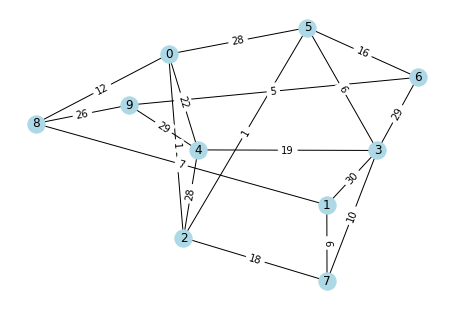

In [24]:
pos = spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue')
edge_labels = dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
_ = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

 ## Algorithmus von Kruskal

Der Algorithmus von Kruskal betrachtet alle Kanten in der Reihenfolge ihrer (aufsteigenden) Kantengewichte und entscheidet, ob sie in den minimalen Spannbaum aufgenommen oder verworfen werden. Wir können abbrechen, sobald alle Knoten verbunden sind, der Spannbaum also #Knoten-1 Kanten hat.

In [14]:
import heapq

class MSTKruskal:
    def __init__(self, graph):
        self.included_edges = []
        self.total_weight = 0
        candidates = []
        # add all edges to priority queue
        for u, v, weight in graph.edges.data('weight'):
            heapq.heappush(candidates, (weight, u, v))
        uf = UnionFind(graph.number_of_nodes())

        while (candidates and
               len(self.included_edges) < graph.number_of_nodes() - 1):
            weight, u, v = heapq.heappop(candidates)
            if uf.connected(u, v):
                print("skipped edge", (u,v), "with weight", weight)
                continue
            uf.union(u, v)
            self.included_edges.append((u,v))
            print("added edge", (u,v), "with weight", weight)
            self.dump()
            self.total_weight += weight

    def edges(self):
        for e in self.included_edges:
            yield e

    def weight(self):
        return self.total_weight
    
    def dump(self):
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_edges(graph, pos, edgelist=self.included_edges, edge_color="r")
        plt.show()

added edge (1, 8) with weight 4


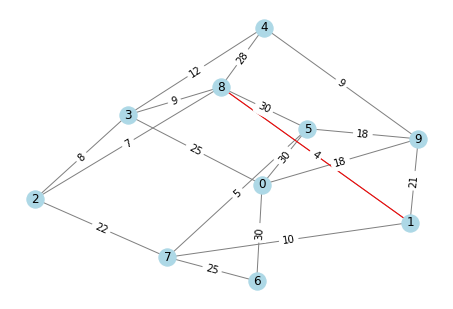

added edge (5, 7) with weight 5


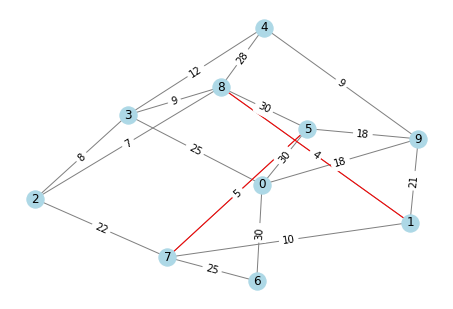

added edge (2, 8) with weight 7


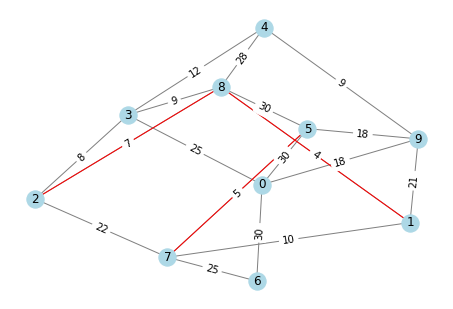

added edge (2, 3) with weight 8


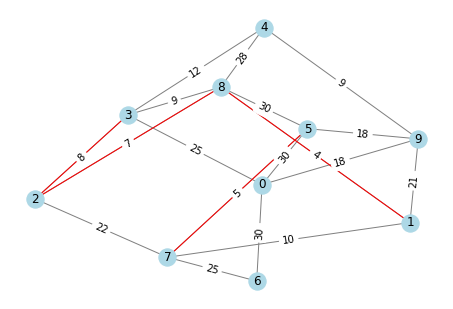

skipped edge (3, 8) with weight 9
added edge (4, 9) with weight 9


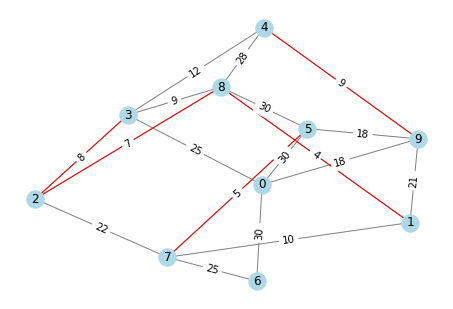

added edge (1, 7) with weight 10


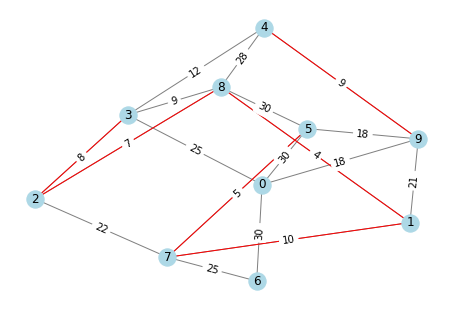

added edge (3, 4) with weight 12


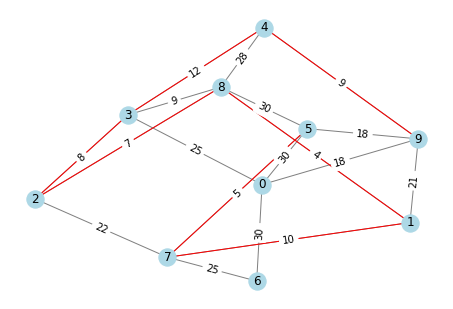

added edge (0, 9) with weight 18


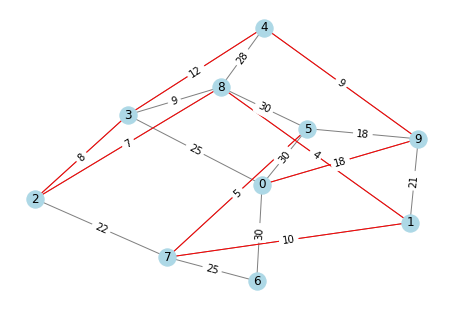

skipped edge (5, 9) with weight 18
skipped edge (1, 9) with weight 21
skipped edge (2, 7) with weight 22
skipped edge (0, 3) with weight 25
added edge (6, 7) with weight 25


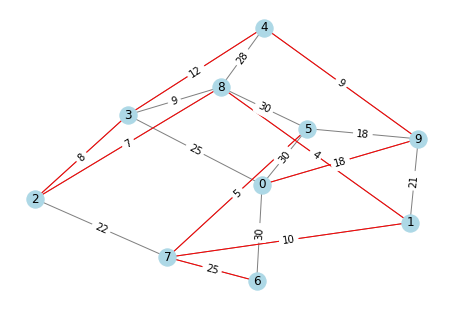

Der minimale Spannbaum hat Gewicht 98


In [18]:
mst = MSTKruskal(graph)
print("Der minimale Spannbaum hat Gewicht", mst.weight())

## Algorithmus von Prim

Der Algorithmus von Prim baut den Spannbaum ausgehend von einem bestimmten Knoten aus auf (wir wählen hier fest Knoten 0). Dabei betrachtet er jeweils eine Kante mit minimalem Gewicht unter allen am aktuellen Baum anliegenden Kanten. Verbindet sie einen neuen Knoten mit dem Baum, wird sie aufgenommen, sonst wird sie verworfen.

In [28]:
class LazyPrim:
    def __init__(self, graph):
        self.included_edges = []
        self.total_weight = 0

        # node-indexed list: True if node already in tree
        included_nodes = [False] * graph.number_of_nodes()
        candidates = []

        # include an arbitrary node (we use 0) in tree
        included_nodes[0] = True
        for node in graph.neighbors(0):
            weight = graph.get_edge_data(0, node)["weight"]
            heapq.heappush(candidates, (weight, 0, node))

        self.dump(candidates)

        while (candidates and
               len(self.included_edges) < graph.number_of_nodes() - 1):
            weight, v, w = heapq.heappop(candidates)

            if included_nodes[v] and included_nodes[w]:
                print("skipped edge", (v, w))
                continue
            if included_nodes[w]:
                v, w = w, v
            # v is in tree, w is not
            included_nodes[w] = True
            self.included_edges.append((v, w))
            print("added edge", (v, w), "with weight", weight)
            self.total_weight += weight
            for node in graph.neighbors(w):
                if not included_nodes[node]:
                    weight = graph.get_edge_data(w, node)["weight"]
                    heapq.heappush(candidates, (weight, w, node))
            self.dump(candidates)

                    
    def edges(self):
        for e in self.included_edges:
            yield e

    def weight(self):
        return self.total_weight
    
    def dump(self, candidates=None):
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_edges(graph, pos, edgelist=self.included_edges, edge_color="r")
        if candidates:
            edges = [(u,v) for (w, u, v) in candidates]
            nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color="b")
        plt.show()

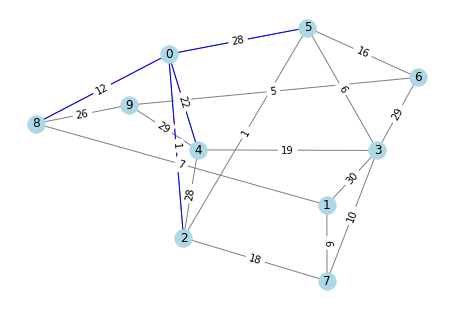

added edge (0, 2) with weight 1


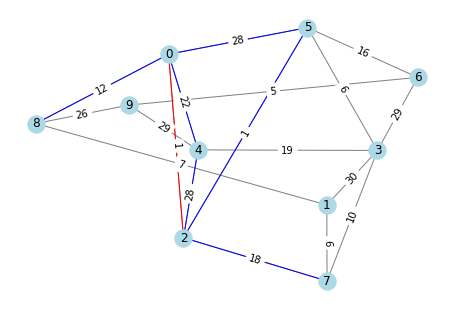

added edge (2, 5) with weight 1


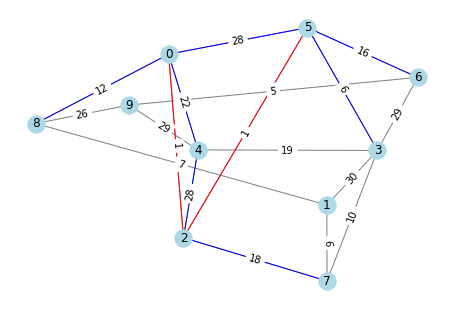

added edge (5, 3) with weight 6


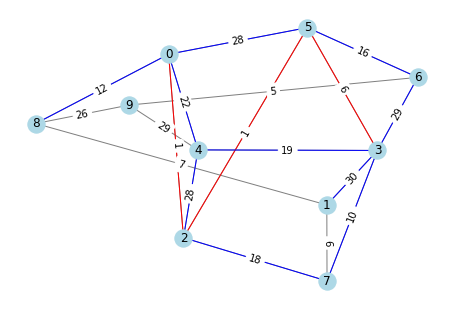

added edge (3, 7) with weight 10


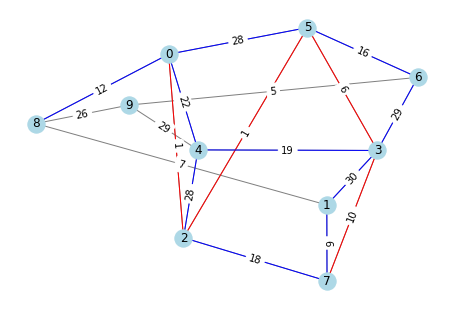

added edge (7, 1) with weight 6


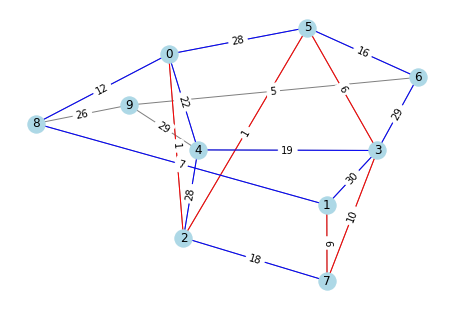

added edge (1, 8) with weight 7


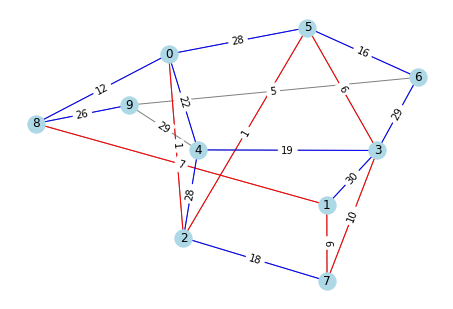

skipped edge (0, 8)
added edge (5, 6) with weight 16


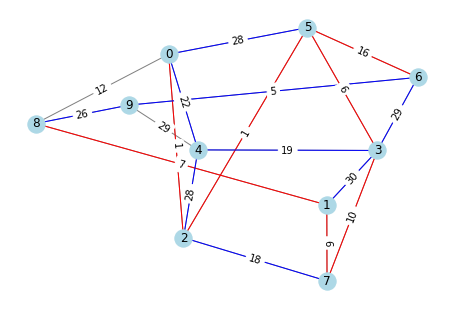

added edge (6, 9) with weight 5


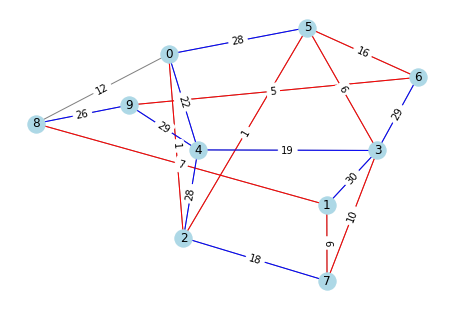

skipped edge (2, 7)
added edge (3, 4) with weight 19


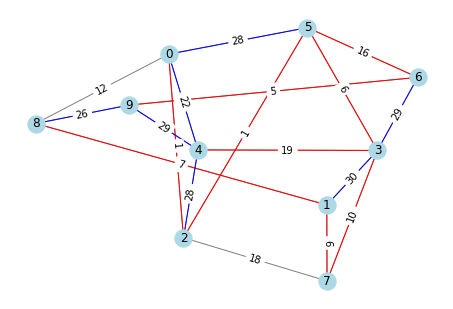

Der minimale Spannbaum hat Gewicht 71


In [29]:
mst = LazyPrim(graph)
print("Der minimale Spannbaum hat Gewicht", mst.weight())